# Football Betting using FiveThirtyEight's Soccer Power Index
## Goal
Backtest a strategy of using the FiveThirtyEight's Soccer Power Index for betting.

## Imports

In [1]:
import concurrent.futures
import io
import json
import os
import warnings
from datetime import datetime

from thefuzz import fuzz
import missingno as msno
import networkx as nx
import numpy as np
import pandas as pd
import requests

warnings.filterwarnings('ignore')

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")


## FiveThirtyEight
Download Soccer Power Index dataset.

In [2]:
SPI_SOCCER_URL = "https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv"

content = requests.get(SPI_SOCCER_URL).content
df_spi = pd.read_csv(io.StringIO(content.decode()))
df_spi["date"] = pd.to_datetime(df_spi["date"], format="%Y-%m-%d")

assert df_spi["date"].isna().sum() == 0

df_spi.sample(5)


,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
63026,2022,2023-02-15,1975,Mexican Primera Division Torneo Clausura,Monterrey,Querétaro,63.67,36.62,0.7195,0.0905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58765,2022,2022-09-18,1854,Italy Serie A,AS Roma,Atalanta,72.46,72.98,0.4190,0.3160,...,70.4,66.3,0.0,1.0,3.27,0.17,2.01,0.42,0.00,1.05
44665,2021,2021-08-13,1869,Spanish Primera Division,Valencia,Getafe,66.96,70.83,0.4058,0.2978,...,25.2,22.6,1.0,0.0,1.56,1.30,0.49,2.45,1.05,0.00
9443,2017,2018-04-10,2412,English League Championship,Ipswich Town,Barnsley,32.78,32.55,0.4161,0.2821,...,0.0,58.8,1.0,0.0,1.43,1.02,1.63,1.77,1.05,0.00
9283,2017,2018-04-07,2412,English League Championship,Millwall,Bristol City,43.98,37.65,0.4951,0.2322,...,14.4,10.2,2.0,0.0,1.79,0.50,0.64,1.09,2.10,0.00


Earliest season.

In [3]:
df_spi["season"].min()


2016

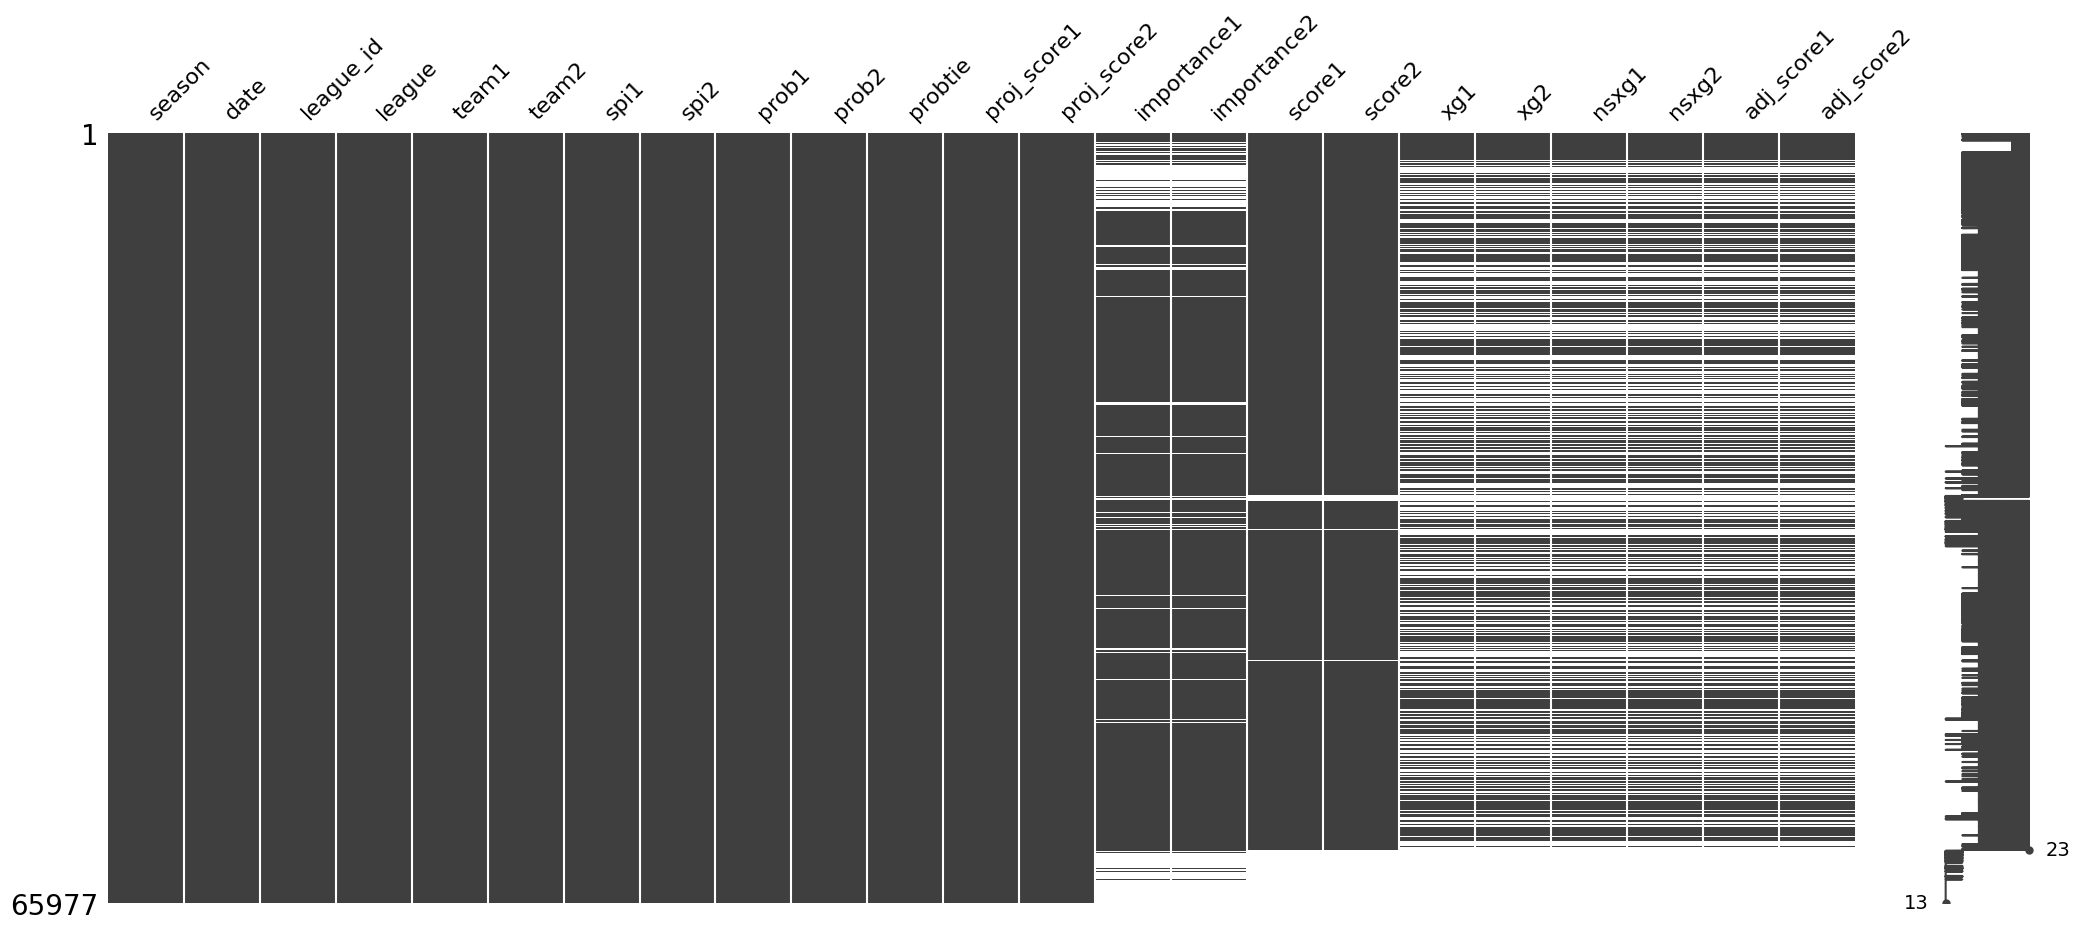

In [4]:
msno.matrix(df_spi.sort_values("date"));

## Football-Data.co.uk
[football-data.co.uk](https://www.football-data.co.uk) is a website that provides historical betting odds for many soccer leagues.

In [5]:
FOOTBALL_DATA_MAIN_URL = "https://www.football-data.co.uk/mmz4281/{season}/{league}.csv"
LEAGUES = {
    "E0": ["Barclays Premier League"],
    "E1": ["English League Championship"],
    "E2": ["English League One"],
    "E3": ["English League Two"],
    "SC0": ["Scottish Premiership"],
    "D1": ["German Bundesliga"],
    "D2": ["German 2. Bundesliga"],
    "I1": ["Italy Serie A"],
    "I2": ["Italy Serie B"],
    "SP1": ["Spanish Primera Division"],
    "SP2": ["Spanish Segunda Division"],
    "F1": ["French Ligue 1"],
    "F2": ["French Ligue 2"],
    "N1": ["Dutch Eredivisie"],
    "B1": ["Belgian Jupiler League"],
    "P1": ["Portuguese Liga"],
    "T1": ["Turkish Turkcell Super Lig"],
    "G1": ["Greek Super League"],
}

FOOTBALL_DATA_OTHER_URL = "https://www.football-data.co.uk/new/{league}.csv"
OTHER_LEAGUES = {
    "ARG": ["Argentina Primera Division"],
    "AUT": ["Austrian T-Mobile Bundesliga"],
    "BRA": ["Brasileiro Série A"],
    "CHN": ["Chinese Super League"],
    "DNK": ["Danish SAS-Ligaen"],
    "JPN": ["Japanese J League"],
    "MEX": ["Mexican Primera Division Torneo Apertura", "Mexican Primera Division Torneo Clausura"],
    "NOR": ["Norwegian Tippeligaen"],
    "RUS": ["Russian Premier Liga"],
    "SWE": ["Swedish Allsvenskan"],
    "SWZ": ["Swiss Raiffeisen Super League"]
}


def url_to_pandas(url):
    """Download URL content to a pandas dataframe."""
    content = requests.get(url).content
    data = pd.read_csv(io.StringIO(content.decode(encoding="latin1")))
    data = data.dropna(how="all", axis=0)
    data = data.dropna(how="all", axis=1)
    data["URL"] = url
    return data


def get_football_data_main(year, league):
    """Get football data."""
    season = str(year - 1)[-2:] + str(year)[-2:]
    url = FOOTBALL_DATA_MAIN_URL.format(season=season, league=league)
    data = url_to_pandas(url)
    data["Season"] = season
    return data


def get_football_data_other(league):
    """Get football data."""
    url = FOOTBALL_DATA_OTHER_URL.format(league=league)
    data = url_to_pandas(url)
    data["Div"] = league
    return data



with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(get_football_data_main, year=year, league=league)
        for league in LEAGUES.keys()
        for year in range(2023, 2015, -1)
    ]
    results_main = [future.result() for future in concurrent.futures.as_completed(futures)]

    futures = [
        executor.submit(get_football_data_other, league=league)
        for league in OTHER_LEAGUES.keys()
    ]
    results_other = [future.result() for future in concurrent.futures.as_completed(futures)]

df_bet_main = pd.concat(results_main)
df_bet_other = pd.concat(results_other)


In [6]:
df_bet_other = df_bet_other.rename(
    columns={
        "Home": "HomeTeam",
        "Away": "AwayTeam",
        "HG": "FTHG",
        "AG": "FTAG",
        "Res": "FTR",
        "PH": "PSH",
        "PD": "PSD",
        "PA": "PSA",
    }
)


In [7]:
df_bet = pd.concat([df_bet_main, df_bet_other])


Dates comes in differents formats depending on the year.

In [8]:
date1 = pd.to_datetime(df_bet["Date"], format="%d/%m/%Y", errors="coerce")
date2 = pd.to_datetime(df_bet["Date"], format="%d/%m/%y", errors="coerce")
df_bet["Date"] = date1.fillna(date2)

assert df_bet["Date"].isna().sum() == 0

df_bet.sample(5)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,HFKC,AFKC,Country,League
123,T1,2021-11-20,16:00,Alanyaspor,Besiktas,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,E1,2016-12-26,NaN,Huddersfield,Nott'm Forest,2.0,1.0,H,0.0,1.0,...,1.97,1.91,1.85,1.75,3.6,4.5,NaN,NaN,NaN,NaN
1809,SWE,2019-07-13,15:00,Falkenbergs,Goteborg,1.0,1.0,D,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sweden,Allsvenskan
273,SP1,2022-03-12,20:00,Getafe,Valencia,0.0,0.0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,E3,2017-11-18,NaN,Lincoln,Coventry,1.0,2.0,A,1.0,0.0,...,1.92,1.97,1.92,2.70,3.0,2.7,NaN,NaN,NaN,NaN


In [9]:
# TEMP

leagues = [league for leagues in LEAGUES.values() for league in leagues]
other_leagues = [league for leagues in OTHER_LEAGUES.values() for league in leagues]

df_spi = (
    df_spi
    .query(f"league in {leagues + other_leagues}")
    .query(f"date < '{datetime.today().date()}'")
)

In [10]:
all_leagues = LEAGUES.copy()
all_leagues.update(OTHER_LEAGUES)

spi_starting_dates = {
    div: df_spi.query(f"league == '{league}'")["date"].min().date().isoformat()
    for div, leagues in all_leagues.items()
    for league in leagues
}

conditionals = [
    f"(Div == '{div}' and Date >= '{start_date}')"
    for div, start_date in spi_starting_dates.items()
]
df_bet = df_bet.query(" or ".join(conditionals))


In [11]:
" or ".join(conditionals)

"(Div == 'E0' and Date >= '2016-08-13') or (Div == 'E1' and Date >= '2017-08-04') or (Div == 'E2' and Date >= '2018-08-04') or (Div == 'E3' and Date >= '2018-08-04') or (Div == 'SC0' and Date >= '2017-08-05') or (Div == 'D1' and Date >= '2016-08-26') or (Div == 'D2' and Date >= '2017-07-28') or (Div == 'I1' and Date >= '2016-08-20') or (Div == 'I2' and Date >= '2017-08-25') or (Div == 'SP1' and Date >= '2016-08-19') or (Div == 'SP2' and Date >= '2017-08-18') or (Div == 'F1' and Date >= '2016-08-12') or (Div == 'F2' and Date >= '2017-07-28') or (Div == 'N1' and Date >= '2017-08-11') or (Div == 'B1' and Date >= '2018-07-27') or (Div == 'P1' and Date >= '2017-08-06') or (Div == 'T1' and Date >= '2017-08-11') or (Div == 'G1' and Date >= '2018-08-25') or (Div == 'ARG' and Date >= '2017-08-25') or (Div == 'AUT' and Date >= '2017-07-22') or (Div == 'BRA' and Date >= '2017-05-13') or (Div == 'CHN' and Date >= '2018-08-01') or (Div == 'DNK' and Date >= '2018-07-13') or (Div == 'JPN' and Date >=

In [12]:
# df_bet["Date"] = df_bet["Date"].dt.date
# df_spi["date"] = df_spi["date"].dt.date

Each data source uses different ways of writing the same clubs names. I will use a dict to make names the same.

In [13]:
# # Generate empty names dict

# frames = [df_spi["team1"], df_spi["team2"], df_bet["HomeTeam"], df_bet["AwayTeam"]]
# names = pd.concat(frames).drop_duplicates()

# pairs = [
#     (name, other_name)
#     for name in names
#     for other_name in names
#     if fuzz.partial_ratio(name, other_name) > 90
# ]

# graph = nx.Graph()
# graph.add_edges_from(pairs)

# clusters = [list(cluster) for cluster in nx.connected_components(graph)]
# clusters = {cluster[0]: cluster for cluster in clusters}
# (
#     pd.Series(clusters)
#     .sort_index()
#     .to_json(os.path.join(DATA_DIR, "names.json"), force_ascii=False)
# )


In [56]:
with open(os.path.join(DATA_DIR, "names.json"), encoding="utf-8") as file:
    names_dict = json.load(file)


names_dict = {
    name.strip(): i.strip()
    for i, name_list in names_dict.items()
    for name in name_list
}


def clean(series, translate_dict):
    """Clean text in pandas series."""
    return (
        series
        .str.strip()
        .apply(lambda x: translate_dict[x] if x in translate_dict else x)
    )


df_spi["team1_clean"] = clean(df_spi["team1"], names_dict)
df_spi["team2_clean"] = clean(df_spi["team2"], names_dict)
df_bet["HomeTeam_clean"] = clean(df_bet["HomeTeam"], names_dict)
df_bet["AwayTeam_clean"] = clean(df_bet["AwayTeam"], names_dict)

spi_teams = set(pd.concat((df_spi["team1_clean"],  df_spi["team2_clean"])))
bet_teams = set(pd.concat((df_bet["HomeTeam_clean"], df_bet["AwayTeam_clean"])))

sym_diff = bet_teams.symmetric_difference(spi_teams)
with open("diff.txt", "w") as file:
    file.write("\n".join(sorted(sym_diff)))


df_bet["date"] = df_bet["Date"]
df_bet["team1_clean"] = df_bet["HomeTeam_clean"]
df_bet["team2_clean"] = df_bet["AwayTeam_clean"]

df = df_spi.merge(df_bet, how="outer", on=["date", "team1_clean", "team2_clean"], validate="1:1", indicator=True)
df.query("_merge == 'left_only'")[["Div", "league", "date", "league", "team1_clean", "team2_clean", "_merge"]].sample(1)

,Div,league,date,league,team1_clean,team2_clean,_merge
16882,NaN,Chinese Super League,2019-03-29,Chinese Super League,Tianjin Teda,Guangzhou R&F,left_only


In [57]:
df_bet.query("Date == '2018-11-24' and Div == 'AUT'")

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,LBA,HFKC,AFKC,Country,League,HomeTeam_clean,AwayTeam_clean,date,team1_clean,team2_clean
1166,AUT,2018-11-24,16:00,Wolfsberger AC,Mattersburg,2.0,2.0,D,NaN,NaN,...,NaN,NaN,NaN,Austria,Bundesliga,Wolfsberger AC,Mattersburg,2018-11-24,Wolfsberger AC,Mattersburg
1167,AUT,2018-11-24,16:00,Admira,Austria Vienna,1.0,2.0,A,NaN,NaN,...,NaN,NaN,NaN,Austria,Bundesliga,Admira,Austria Vienna,2018-11-24,Admira,Austria Vienna
1168,AUT,2018-11-24,16:00,Hartberg,Salzburg,0.0,4.0,A,NaN,NaN,...,NaN,NaN,NaN,Austria,Bundesliga,Hartberg,Salzburg,2018-11-24,Hartberg,Salzburg


There are only a few clubs left that are unmatch. Maybe one dataset has more games than the other.

Now that names are fixed, it is able to be merged.

In [45]:
df_bet = df_bet.rename(
    {"Date": "date", "HomeTeam_clean": "team1_clean", "AwayTeam_clean": "team2_clean"}, axis=1
)

# df_bet_minus = df_bet.copy()
# df_bet_minus["date"] = df_bet_minus["date"] - pd.Timedelta(days=1)

# df_bet_plus = df_bet.copy()
# df_bet_plus["date"] = df_bet_plus["date"] + pd.Timedelta(days=1)

# df_bet = df_bet.append(df_bet_minus)
# df_bet = df_bet.append(df_bet_plus)


AttributeError: Can only use .dt accessor with datetimelike values

In [46]:
df = df_spi.merge(df_bet, how="outer", on=["date", "team1_clean", "team2_clean"], validate="1:1", indicator=True)

print(df_spi.shape[0] - df.shape[0])

ValueError: The column label 'team1_clean' is not unique.

In [47]:
df.query("_merge == 'left_only'")[["date", "league", "team1_clean", "team2_clean", "_merge"]]

,date,league,team1_clean,team2_clean,_merge
9,2016-08-13,Barclays Premier League,Manchester City,Sunderland,left_only
14,2016-08-14,Barclays Premier League,Bournemouth,Manchester United,left_only
21,2016-08-19,Spanish Primera Division,Málaga,Osasuna,left_only
22,2016-08-19,Barclays Premier League,Manchester United,Southampton,left_only
23,2016-08-19,Spanish Primera Division,Deportivo La Coruña,Eibar,left_only
...,...,...,...,...,...
40111,2023-06-04,Spanish Primera Division,Villarreal B,Atletico Madrid,left_only
40112,2023-06-04,Spanish Primera Division,Celta,Barcelona,left_only
40113,2023-06-04,Spanish Primera Division,Real Sociedad,Sevilla,left_only
40114,2023-06-04,Spanish Primera Division,Real Valladolid,Getafe,left_only


Add each results point of view to the dataset.

In [8]:
df["win"] = df["score1"] > df["score2"]
df["draw"] = df["score1"] == df["score2"]
df["loss"] = df["score1"] < df["score2"]

df_inv = df.copy()

df_inv["team2"], df_inv["team1"] = df["team1"], df["team2"]
df_inv["spi2"], df_inv["spi1"] = df["spi1"], df["spi2"]
df_inv["prob2"], df_inv["prob1"] = df["prob1"], df["prob2"]
df_inv["proj_score2"], df_inv["proj_score1"] = df["proj_score1"], df["proj_score2"]
df_inv["importance2"], df_inv["importance1"] = df["importance1"], df["importance2"]
df_inv["score2"], df_inv["score1"] = df["score1"], df["score2"]
df_inv["xg2"], df_inv["xg1"] = df["xg1"], df["xg2"]
df_inv["nsxg2"], df_inv["nsxg1"] = df["nsxg1"], df["nsxg2"]
df_inv["adj_score2"], df_inv["adj_score1"] = df["adj_score1"], df["adj_score2"]
df_inv["B365A"], df_inv["B365H"] = df["B365H"], df["B365A"]
df_inv["MaxA"], df_inv["MaxH"] = df["MaxH"], df["MaxA"]
df_inv["AvgA"], df_inv["AvgH"] = df["AvgH"], df["AvgA"]
df_inv["loss"], df_inv["win"] = df["win"], df["loss"]

df_draw = df.copy()
df_draw["team1"] = "draw"
df_draw["team2"] = np.nan
df_draw["prob1"] = df["probtie"]
df_draw["B365H"] = df["B365D"]
df_draw["MaxH"] = df["MaxD"]
df_draw["AvgH"] = df["AvgD"]
df_draw["win"] = df["draw"]

df = df.append(df_inv).reset_index(drop=True)
df = df.append(df_draw).reset_index(drop=True)

print(df.shape)

df.sample(5)


(5088, 150)


,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,win,draw,loss
2363,2018,2019-03-03,2411,Barclays Premier League,chelsea,fulham,84.02,56.99,0.6604,0.1354,...,2.09,2.02,1.90,1.84,NaN,NaN,NaN,True,False,False
2870,2020,2020-10-04,2411,Barclays Premier League,sheffield united,arsenal,66.93,78.69,0.1772,0.5815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
2126,2018,2018-09-22,2411,Barclays Premier League,watford,fulham,69.59,61.89,0.3389,0.3858,...,2.17,2.12,1.82,1.77,NaN,NaN,NaN,False,True,False
4263,2019,2019-11-09,2411,Barclays Premier League,draw,NaN,86.49,70.40,0.1774,0.1056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1143,2020,2020-09-12,2411,Barclays Premier League,west ham,newcastle,70.38,64.72,0.4887,0.2556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True


## Results
### ROI Lines

In [9]:
def roi_lines(data, odds_col):
    """Calculate ROI."""
    data["ev"] = data["prob1"] * (data[odds_col] - 1) - (1 - data["prob1"])
    data["bet"] = data["ev"] > 0
    data["balance"] = data["bet"].astype(int) * (
        data["win"].astype(int) * data[odds_col] - 1
    )

    return data["balance"].sum() / data["bet"].sum()


print(f"Avg ROI = {roi_lines(df, 'AvgH') * 100:.2g}%")
print(f"B365 ROI = {roi_lines(df, 'B365H') * 100:.2g}%")
print(f"Max ROI = {roi_lines(df, 'MaxH') * 100:.2g}%")


Avg ROI = -1.7%
B365 ROI = 2.1%
Max ROI = 3.6%


### ROI Over/Under

In [10]:
df[">2.5"] = df["score1"] + df["score2"] > 2.5
df["<2.5"] = df["score1"] + df["score2"] < 2.5


def roi_over_under(data, odds_col):
    """Calculate ROI."""
    pd.options.mode.chained_assignment = None
    data = data.dropna(subset=[f"{odds_col}<2.5", f"{odds_col}>2.5", "team2"])
    data["bet_over"] = data["x>2.5"].astype(int)
    data["bet_under"] = data["x<2.5"].astype(int)
    data["balance_over"] = data["bet_over"] * (
        data[">2.5"].astype(int) * df[f"{odds_col}>2.5"] - 1
    )
    data["balance_under"] = data["bet_under"] * (
        data["<2.5"].astype(int) * df[f"{odds_col}<2.5"] - 1
    )
    data["balance"] = data["balance_over"] + data["balance_under"]
    return data["balance"].sum() / data["bet"].sum()


df["x>2.5"] = df["proj_score1"] + df["proj_score1"] > 2.5
df["x<2.5"] = df["proj_score1"] + df["proj_score1"] < 2.5

print(f"Avg ROI = {roi_over_under(df, 'Avg') * 100:.2g}%")
print(f"B365 ROI = {roi_over_under(df, 'B365') * 100:.2g}%")
print(f"Max ROI = {roi_over_under(df, 'Max') * 100:.2g}%")


Avg ROI = -7.3%
B365 ROI = -8.1%
Max ROI = -0.29%


## Conclusion
### Lines
This strategy would lose money against the average betting site. However, it is able to have a small margin agains some specific websites that offers good odds.

### Over/Under
The over/under strategy is not profitable, even considering the best odds available.